## ISC within and across samples, Run4

This analysis examines the data for run 4 pair-by-pair. 
We first loat the data and compute pairwise ISC for run4 (with phaseshift-permutations)
Next, we split the pairwise ISC matrix based on whether it was from a within-comparison (i.e. collapsing over all ISCs that were french-french, chinese-chinese, or english-english).
Then, we also collapse over all across-ISC comparisons (i.e. the ones french-chinese, french-english, english-chinese)


### Import Modules

In [2]:
import pickle 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys, os, nilearn
from nilearn import datasets, plotting
import nilearn.connectome
from scipy.spatial.distance import squareform
from statsmodels.stats.multitest import multipletests
%matplotlib inline
sys.path.append("..")
from lpp_utils import *
sns.set_context("poster", font_scale = 0.8, rc={"grid.linewidth": 0.6});

#### Load data, prepare result variables

In [12]:
result_within = []; result_across = []

curr_run = 0 # only work for run 1 in this notebook
print(curr_run)

n_perm = 500
print(n_perm)

target_size = [291, 315, 338, 308, 283, 371, 340, 293, 368]
curr_target_size = target_size[curr_run]
print(curr_target_size)

data_fr = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppFR-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
data_cn = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppCN-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
data_en = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppEN-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
       
    
n_regions =  data_fr.shape[1]
print(n_regions)
    
all_data = np.concatenate([data_fr, data_cn, data_en], axis =2)

result_all = lpp_isc(all_data[15:-10 ,:,:], pairwise=True)  # exclude first 15 and last 10 TRs
result_within_lang = np.zeros((n_regions,1))
result_across_lang = np.zeros((n_regions,1))

surr_result_within_lang = np.zeros((n_perm, n_regions))
surr_result_across_lang = np.zeros((n_perm, n_regions))

0
500
291
293
Assuming 110 subjects with 266 time points and 293 voxel(s) or ROI(s).


#### Loop across runs, compute within- and across language ISC

In [9]:
# First, compute ISC
observed_all, distribution = phaseshift_isc_pairwise(all_data[15:-10 ,:,:], pairwise=True, summary_statistic= None, n_shifts= n_perm)
# also, to get rid of transients, cutting off volumes at the beginning and end.

# Second, go over all reagions and collapse the data into within/across ISC
for curr_region in range(n_regions):  
        #print(curr_region)
        
        # aggregate over within/across ISC for the real data
        resmat = squareform(observed_all[:,curr_region])

        w_f = nilearn.connectome.sym_matrix_to_vec(resmat[0:27, 0:27], discard_diagonal=True)  #the numbers here are critical, tested many times (see notebook for concept figure)
        #w_c = nilearn.connectome.sym_matrix_to_vec(resmat[27:60, 27:60], discard_diagonal=True)
        w_e = nilearn.connectome.sym_matrix_to_vec(resmat[60:110, 60:110], discard_diagonal=True)
        
        #a_ec = resmat[27:60, 0:27].flatten()
        #a_fc = resmat[60:110, 0:27].flatten()
        a_ef = resmat[60:110, 27:60].flatten()

        result_within_lang[curr_region] = np.concatenate([w_f, w_e]).mean()     #np.concatenate([w_f, w_c, w_e]).mean()
        result_across_lang[curr_region] = np.concatenate([a_ef]).mean()  #np.concatenate([a_ec, a_fc, a_ef]).mean()   
        
        # aggregate within/across for the surrogate data
        for curr_perm in range(n_perm):
            resmat = squareform(distribution[curr_perm, :, curr_region])   #(20, 5995, 293)
        
            w_f = nilearn.connectome.sym_matrix_to_vec(resmat[0:27, 0:27], discard_diagonal=True)
            #w_c = nilearn.connectome.sym_matrix_to_vec(resmat[27:60, 27:60], discard_diagonal=True)
            w_e = nilearn.connectome.sym_matrix_to_vec(resmat[60:110, 60:110], discard_diagonal=True)

            #a_ec = resmat[27:60, 0:27].flatten()
            #a_fc = resmat[60:110, 0:27].flatten()
            a_ef = resmat[60:110, 27:60].flatten() 
            
            surr_result_within_lang[curr_perm, curr_region] = np.concatenate([w_f, w_e]).mean() #np.concatenate([w_f, w_c, w_e]).mean()
            surr_result_across_lang[curr_perm, curr_region] = np.concatenate([a_ef]).mean()  #np.concatenate([a_ec, a_fc, a_ef]).mean()    
        
result_within.append(result_within_lang);               result_across.append(result_across_lang)
result_within = np.squeeze(np.asarray(result_within));  result_across = np.squeeze(np.asarray(result_across))
result_within = result_within.reshape((1,293));         result_across = result_across.reshape((1,293))

### Plot results, statistics correction, brain plot

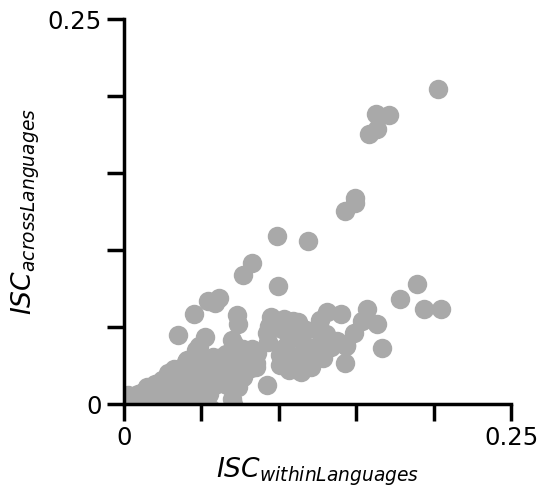

In [10]:
fig, ax = plt.subplots(figsize = (5,5))
plt.scatter(result_within.T, result_across.T, color = 'darkgray');

plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])

plt.xlim([0, 0.25])
plt.ylim([0, 0.25])
ax.set_xticklabels([0,"", "", "", "", 0.25])
ax.set_yticklabels([0,"", "", "", "", 0.25])

plt.xlabel('$ISC_{withinLanguages}$')
plt.ylabel('$ISC_{acrossLanguages}$')
sns.despine()

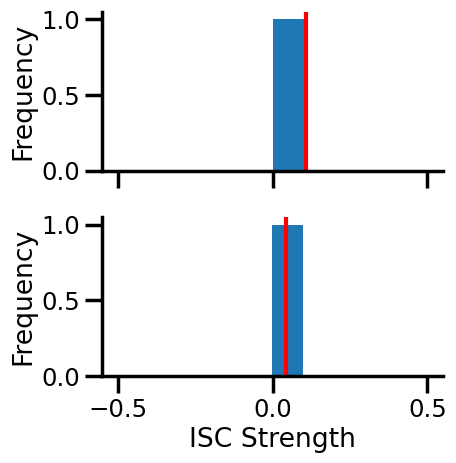

In [11]:

curr_region = 89

# Create the figure and subplots
fig, axs = plt.subplots(2, 1, sharex=True, sharey = True, figsize = (5,5))

# Plot the data on each subplot
axs[0].hist(surr_result_within_lang[:,curr_region])
axs[0].axvline(result_within[0,curr_region], color = 'r')

axs[1].hist(surr_result_across_lang[:,curr_region])
axs[1].axvline(result_across[0,curr_region], color = 'r')

# Set the labels for each subplot
axs[0].set_xlabel('')
axs[0].set_ylabel('Frequency')
axs[1].set_xlabel('ISC Strength')
axs[1].set_ylabel('Frequency')

# Adjust the layout
plt.tight_layout()
sns.despine()



### stats

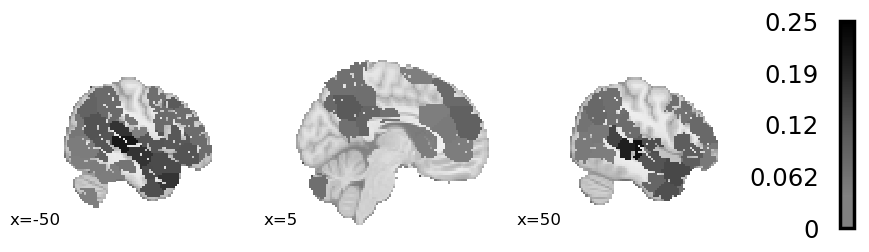

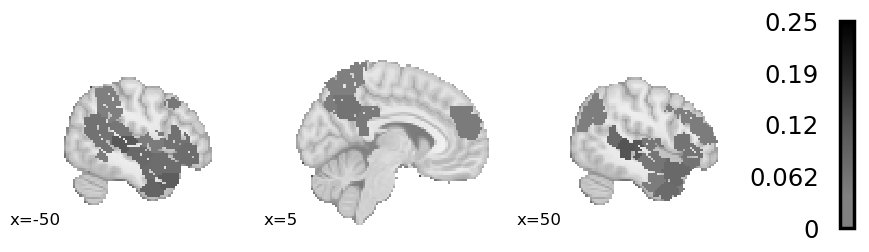

In [80]:
p_values_within = np.zeros(293); p_values_across = np.zeros(293)

for curr_region in range(293):
    p_values_within[curr_region] = p_from_null(result_within[0,curr_region], 
                                            surr_result_within_lang[:,curr_region],
                                            side='two-sided', exact=False)
    
    p_values_across[curr_region] = p_from_null(result_across[0,curr_region], 
                                            surr_result_across_lang[:,curr_region],
                                            side='two-sided', exact=False)

stats_threshold = 0.05

q = multipletests(p_values_within, method='fdr_by')[1]
corrected_within_true = q  < stats_threshold
corrected_within = np.zeros(result_within[0,:].shape)
corrected_within[corrected_within_true] = result_within[0, corrected_within_true]

q = multipletests(p_values_across, method='fdr_by')[1]
corrected_across_true = q  < stats_threshold
corrected_across = np.zeros(result_across[0,:].shape)
corrected_across[corrected_across_true] = result_across[0, corrected_across_true]

file = open('../../data_lpp/fmri_data/other/all293_masker_pickled.obj', 'rb') 
all293_masker_reopened = pickle.load(file)
file.close();


val_v_max = 0.25
v_thresh  = 0.04
slices_to_plot = [-50, 5, 50]

plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(corrected_within, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Greys',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = v_thresh,  vmax = val_v_max);

plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(corrected_across, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Greys',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = v_thresh,  vmax = val_v_max);